
# PS2: Mini-batch SGD, CNN, and RNN

Advanced Learning 2024/5.


Last updated: 2024-12-26


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 342766763
~~~

~~~
STUDENT GIT LINK: https://github.com/mickaelAssous/52025
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS2_CNN_RNN_2024_ID_[342766763].html`   




---


Imports:

In [1]:
import numpy as np # You are allowed to use  only numpy.
import time, sys, cProfile
import matplotlib.pyplot as plt

Please import the objects in `src.py` file into the workspace

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
your_drive_path_to_src_file = "/content/drive/MyDrive/"
sys.path.append(your_drive_path_to_src_file)


In [4]:
from  src import *

Note that now all of the network's objects from PS1 are loaded into the workspace.

---

### 0. Loading data

As in PS1, you will evaluate your home-made network on the `mnist` dataset.   
The MNIST dataset is a large dataset of handwritten digits that is commonly used for training various image and vision models.  



In [5]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---

## PS2 Part 1: Mini-batch SGD



**Welcome back**.   






Mini-batch Stochastic Gradient Descent (Mini-batch SGD) is an optimization algorithm used to train machine learning models, particularly neural networks. It strikes a balance between two other methods:

    Batch Gradient Descent – Uses the entire dataset to compute gradients and update the model parameters.
        ✅ Accurate gradients
        ❌ Slow and memory-intensive for large datasets

    Stochastic Gradient Descent (SGD) – Uses a single data point to compute gradients for each update.
        ✅ Fast and efficient
        ❌ Noisy updates, which can lead to instability

  
**Mini-batch SGD**.

Mini-batch SGD computes gradients and updates the model parameters using small, randomly selected batches of data (typically 32, 64, or 128 samples).

    ✅ Faster than batch gradient descent
    ✅ Less noisy than pure SGD
    ✅ Efficient use of memory
    ✅ Enables vectorization for faster computation on GPUs

**How it Works**.

    Shuffle the dataset to avoid bias.

    Divide the data into small batches (e.g., 64 samples per batch).

    For each epoch, iterate through the mini-batches:
        Perform forward pass to calculate predictions.
        Compute the loss for the mini-batch.
        Perform backpropagation to compute gradients.
        Update model parameters using the gradients.

    Repeat until the model converges.

**Algorithm**

For each mini-batch $B={x_1,x_2,...,x_m}B={x_1​,x_2​,...,x_m​}$ of size $m$, update the weights $w$ as:    

$$
w=w−η⋅\frac{1}{m}∑_{i=1}^m ∇L(w,x_i)
$$

Where:   
*  $η$ = learning rate.
* $∇L(w,x_i)$ = gradient of the loss for sample $x_i$.   

Advantages

    Efficient and scalable – Works well with large datasets.
    Smooth convergence – Less noisy than SGD but faster than full batch training.
    Parallelization – Batches can be processed in parallel on GPUs.

Disadvantages

    Choosing batch size can affect performance. Small batches lead to noise, large batches consume more memory.
    Convergence may be slower than batch gradient descent for some problems.


### Mini-batch Questions.
**P1Q1**:  

Please answer the following questions providing statistical justifications and mathematical formulas when needed.

P1Q1a: Explain how the mini-batch size impacts convergence, model performance, and computational efficiency.



In mini-batch SGD (Stochastic Gradient Descent), the mini-batch size plays a critical role. A smaller mini-batch introduces more noise into the gradient computation, which can help the model escape from local minima in non-convex problems but slows down convergence. Larger mini-batches, on the other hand, provide more accurate gradient estimates, leading to smoother and potentially faster convergence. However, they may require more computational resources and risk getting stuck in suboptimal solutions. Computationally, smaller mini-batches are less efficient as they underutilize hardware, while larger ones make better use of GPUs but require more memory.

P1Q1b:
Why does mini-batch SGD require a learning rate schedule, and what are the common scheduling strategies?



In mini-batch SGD, having a learning rate schedule is crucial for guiding the optimization process. If the learning rate is set too high, the model can become unstable, oscillating or even failing to converge. On the other hand, if it’s too low, the training process can drag on for far too long. To address this, there are a few popular strategies. Step decay reduces the learning rate by a fixed amount after a certain number of iterations. Exponential decay gradually lowers it over time. Then there are adaptive methods like Adam, which automatically adjust the learning rate based on the gradients calculated during training, making the process more efficient and reliable.

P1Q1c: What role does batch normalization play in mini-batch SGD, and why is it essential for deep neural networks?



Batch normalization normalizes the input of each layer during training to have a mean of 0 and a variance of 1 within a mini-batch. This helps stabilize and speed up training by reducing the internal covariate shift. It also enables the use of higher learning rates and acts as a regularizer, improving generalization. For deep networks, this normalization ensures gradients flow effectively, preventing issues like vanishing or exploding gradients.

P1Q1d: How does mini-batch SGD differ in performance compared to full-batch gradient descent when dealing with non-convex optimization problems?



Mini-batch SGD performs better in non-convex optimization problems because the noise introduced by mini-batches helps escape from local minima or saddle points. Full-batch gradient descent, which computes gradients over the entire dataset, converges deterministically but risks getting stuck in suboptimal solutions. Mini-batch SGD is also computationally more efficient, especially for large datasets, as it updates the model more frequently.

P1Q1e: How does mini-batch SGD perform when training on imbalanced datasets, and what strategies can mitigate its challenges?



On imbalanced datasets, mini-batch SGD may produce biased updates toward the majority class, leading to poor model performance. Strategies to address this include using weighted loss functions to give more importance to the minority class, oversampling or undersampling to balance mini-batches, and generating synthetic samples with methods like SMOTE. Another option is stratified sampling to ensure each mini-batch has a balanced representation of all classes.

P1Q1f: Explain why larger mini-batch sizes are preferred during inference but not necessarily during training.


During inference, larger mini-batches maximize computational efficiency because gradients don’t need to be calculated, reducing memory and computation demands. During training, smaller mini-batches introduce stochasticity, which helps improve generalization and avoids overfitting. Larger mini-batches in training can lead to less effective learning and poorer generalization because they lack this beneficial noise.

### Applying mini-batch SGD

Preparing the data:

In [6]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = to_categorical(y_test)

P1Q2a:  

Add a new function to the class `MyNetwork` named `fit_mini_batch`. This function should be similar to `fit`, just with a mini-batch SGD implementation. You can also make other code changes to the scripts in `src` if you think they are needed. In addition, add a suitable learning rate scheduler of your choice.   


YOU SHOULD (a) add the missing script to the src code, and (b) make a copy of the function  below for review

In [7]:
### MISSING: YOUR CODE HERE

def fit_mini_batch(self, x_train, y_train, batch_size, epochs, learning_rate):
        """
        Trains the network using mini-batch gradient descent.

        Parameters:
          x_train : np.array
              Training data.
          y_train : np.array
              Training labels.
          batch_size : int
              Size of each mini-batch.
          epochs : int
              Number of training epochs.
          learning_rate : float or callable
              Learning rate for updating the weights, or a callable function for learning rate scheduling.
          lr_scheduler : callable, optional
              A learning rate scheduler function.
        """
        samples = len(x_train)
        print("Training on {:,} samples using mini-batch SGD:".format(samples))

        for epoch in range(epochs):
            total_loss = 0
            indices = np.random.permutation(samples)  # Shuffle training data
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, samples, batch_size):
                # Get mini-batch
                x_batch = x_train_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                batch_loss = 0
                batch_gradients = [np.zeros_like(layer.weights) if hasattr(layer, 'weights') else None for layer in self.layers]  # Initialize gradients for each layer

                # Forward and backward propagation for each sample in the mini-batch
                for j in range(len(x_batch)):
                    output = x_batch[j]
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    batch_loss += self.loss(y_batch[j], output)
                    grad = self.loss_grad(y_batch[j], output)

                    # Apply backward propagation for each layer
                    for layer in reversed(self.layers):
                        if hasattr(layer, 'weights'):  # Only update weights in layers that have them
                            grad = layer.backward_propagation(grad, learning_rate)

                batch_loss /= len(x_batch)  # Average loss for the mini-batch
                total_loss += batch_loss

            avg_loss = total_loss / (samples // batch_size)  # Average loss across all mini-batches
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Learning Rate: {learning_rate:.6f}")


    Test the two networks below to compare the differences between GD and mini-batch SGD:

In [8]:
#### GD implementaiton ####

# Network Architecture
netGD = MyNetwork()


netGD.add(Affine_Layer(28*28, 128))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(128, 64))
netGD.add(ActivationLayer(tanh, tanh_grad))
netGD.add(Affine_Layer(64, 10))
netGD.add(ActivationLayer(tanh, tanh_grad))

netGD.use_loss(mse, mse_grad)


epoch_num = 10
lr = 0.05
t1 = time.time()
netGD.fit(x_train[:10000], y_train[:10000], epochs=epoch_num, learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training on 10,000 samples:
Training epoch 1/10   error=0.042845
Training epoch 2/10   error=0.023997
Training epoch 3/10   error=0.018123
Training epoch 4/10   error=0.015042
Training epoch 5/10   error=0.013028
Training epoch 6/10   error=0.011540
Training epoch 7/10   error=0.010366
Training epoch 8/10   error=0.009402
Training epoch 9/10   error=0.008586
Training epoch 10/10   error=0.007880
Total process time: 94.072


In [9]:
output_GD = netGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0117, Accuracy: 9358/10000 (94%)



In [10]:
#### mini-batch SGD implementaiton ####

# Network Architecture
netMiniGD = MyNetwork()


netMiniGD.add(Affine_Layer(28*28, 128))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(128, 64))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))
netMiniGD.add(Affine_Layer(64, 10))
netMiniGD.add(ActivationLayer(tanh, tanh_grad))

netMiniGD.use_loss(mse, mse_grad)


epoch_num = 10
lr_sched = 0.05 # add a learning rate scheduler of your choice here
t2 = time.time()
netMiniGD.fit_mini_batch(x_train[:10000], y_train[:10000], batch_size=128, epochs=epoch_num, learning_rate=lr_sched)
print(f"Total process time: {round(time.time() - t2,3)}")


Training on 10,000 samples using mini-batch SGD:
Epoch 1/10, Loss: 0.0533, Learning Rate: 0.050000
Epoch 2/10, Loss: 0.0469, Learning Rate: 0.050000
Epoch 3/10, Loss: 0.0455, Learning Rate: 0.050000
Epoch 4/10, Loss: 0.0448, Learning Rate: 0.050000
Epoch 5/10, Loss: 0.0442, Learning Rate: 0.050000
Epoch 6/10, Loss: 0.0438, Learning Rate: 0.050000
Epoch 7/10, Loss: 0.0436, Learning Rate: 0.050000
Epoch 8/10, Loss: 0.0434, Learning Rate: 0.050000
Epoch 9/10, Loss: 0.0432, Learning Rate: 0.050000
Epoch 10/10, Loss: 0.0431, Learning Rate: 0.050000
Total process time: 83.724


In [11]:
outputMiniGSD = netMiniGD.predict(x_test ,y_test )


Test set: Avg. loss: 0.0452, Accuracy: 8302/10000 (83%)



P1Q2b:   
Please answer the following:
* Which implementation was faster?
* with lower training error?
* with better test accuracy?    

and explain how these results fit your answers in Q1A.

The mini-batch SGD implementation was quicker, completing in 83.72 seconds compared to 94.07 seconds for Gradient Descent (GD). This difference is due to mini-batch SGD updating the model’s weights more often by working with smaller batches of data, which speeds up the process.

GD had a lower training error. The error for GD was about 0.007, while for mini-batch SGD, it was 0.043. This makes sense because GD uses the full dataset to calculate the gradient, leading to more accurate updates. Mini-batch SGD, however, uses only a small portion of the data at each step. This can make the updates less accurate and lead to a higher training error.

GD also performed better on the test set, achieving an accuracy of 94%, while mini-batch SGD reached 83%. The more precise updates in GD helped it perform better on unseen data, while the noisier updates in mini-batch SGD led to lower accuracy.

Q1A explains that mini-batch size affects convergence and performance: smaller mini-batches introduce more noise, helping the model escape local minima but making convergence slower and less stable. Larger mini-batches lead to smoother and faster convergence but might miss optimal solutions.
In our case, mini-batch SGD was faster, but its noisier updates caused it to perform worse on both the training and test sets.
GD, with its more precise updates, converged slower but achieved better accuracy because it worked with the whole dataset each time, making the gradient estimates more reliable.

## PS2 Part 2: CNN



A Convolutional Neural Network (CNN) is a type of a deep neural network that can perform well at image recognition and analysis tasks.


> In this problem set we will add CNN compatibility to our numpy-based neural network from PS 1.

The main components needed to implement a CNN architecture:  

**Convolution layer:** In the convolutional layers, filters are applied to the image to identify patterns and features. Imagine a sliding window that moves across the image, detecting edges, shapes, and other building blocks.  

**Pooling layer:** Pooling layers downsample the data, reducing its complexity and computational cost. This helps prevent overfitting, where the model memorizes training data instead of learning generalizable patterns.  

**Reshape layer:**
Reshaping the output of the convolution and pooling layers into the fully connected layer.   


A USEFUL HINT:

*Keeping account of the input and output shapes along the CNN network is crucial for the model to work as intended*



Useful resource:  
* [CS231](https://cs231n.github.io/convolutional-networks/).
* [Convolutional Neural Network From Scratch](https://www.kaggle.com/code/lusfernandotorres/convolutional-neural-network-from-scratch).
* [CNN with PyTorch](https://www.kaggle.com/code/sdelecourt/cnn-with-pytorch-for-mnist)

#### Data transformations





(Here I added a reshape that I originally intended for you to apply at model time).

In [33]:
from keras.datasets import mnist
from keras.utils import to_categorical
# load MNIST from server
# Using a standard library (keras.datasets) to load the mnist data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [34]:
# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.astype('float32')
x_train /= 255
x_train = x_train.reshape(x_train.shape[0],1,
                          x_train.shape[1],x_train.shape[2])
# One-hot encoding of the output.
# Currently a number in range [0,9]; Change into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],1,
                          y_train.shape[1])

# same for test data : 10000 samples
x_test = x_test.astype('float32')
x_test /= 255
x_test = x_test.reshape(x_test.shape[0],1,
                          x_test.shape[1],x_test.shape[2])
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],1,
                          y_test.shape[1])

In [14]:
print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)


x_train shape (60000, 1, 28, 28)
x_test shape (10000, 1, 28, 28)
y_train shape (60000, 1, 10)
y_test shape (10000, 1, 10)


Unlike the multilayer perceptron (MLP) architecture, the input to the convolution net is not flattened. In our case, the size of a single `MNIST` datapoint is (1,28,28). The first dimension is the number of channels (e.g. RGB  for color images). During training the inputs and outputs often  change shape as they pass through the convolution, pooling, and the other layers of the network.

---

### A. Convolution Layer

Here you are asked to implement a basic Convolution layer with the following components:



1.   Layer initialization - initialize the layer's filters using Normalized Xavier/Hu weights
2.   A generator function that yields all the available sliding windows in the input image.
3.   Forward propogation for the convolution layer
4.   Backward propogation for the convolution layer

[CS231](https://cs231n.github.io/convolutional-networks/#conv) provides a great overview both mathematically and visually,   
and [CS230](https://cs230.stanford.edu/section/4/) provides a good overview about Xavier initialization.




P2Q1a:  (10pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.    
You can deviate slightly from the recommended structure below, but please remain true to the class structure and compatibility with the rest of the network classes and functions. The idea here is to write YOUR OWN version of CNN, so please try not to google the answers.





In [6]:
### MISSING: SOLUTION REQUIRED IN THIS CODE BLOCK

class Convolution:
    # convolution layer using num_filters x num_filters filters.
    # size is the length/width of the filter window with shape (size x size)
    # In this simple implementation, there is no padding.

    def __init__(self, num_filters=3, size=3, activation=None):
        self.stride = 1 # for simplicity, we keep the stride=1.
        self.size = size
        self.activation = activation
        self.last_input = None


        # Initialize the Convolution layer filters
        ## SOLUTION REQUIRED!!
        self.filters = np.random.randn(num_filters, size, size) / np.sqrt(size * size)


    def patch_generator(self, image):
        # This generator (using yield) returns all the  possible patches of  the input image
        # of shape  (h,w)  for each channel c, together with the relevant y,x coordinates of the patch.
        # input_data/image must be shaped as (c,y,x), where c is the channel/filter
        ch,h,w = image.shape

        for y in range(0,h-self.size+1):
            for x in range(0,w-self.size+1,self.stride):
                ## SOLUTION REQUIRED!!
                patch = image[:, y:y+self.size, x:x+self.size]
                yield patch, y, x


    def forward_propagation(self, image):
        # Calculate the convolution forward pass using the filters together with a
        # user specified activation function.

        # If this is the first convolution layer, the input image is size (h,w) and must be expanded to (c,h,w).
        if len(image.shape)==2:
            image = np.expand_dims(image, axis=0)
        # keep track of last input for later backward propagation
        self.last_input = image
        ch, h, w = image.shape
        # Initializing the output array:
        ## SOLUTION REQUIRED!!
        input_dimension = h # the dimension of the input (current) image
        output_dimension = h - self.size + 1

        # compute output dimensions after the convolution layer
        output = np.zeros((self.filters.shape[0], output_dimension, output_dimension))

        # forward pass on each filter
        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(image):
                ## SOLUTION REQUIRED!!
                output[f,y, x] = np.sum(patch * self.filters[f])

        # Applying activation function (this is a small cheat/simplification
        #  because the activation should be a separate layer in itself.  )
        if self.activation is not None:
            output = self.activation.forward_propagation(output)
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the SGD in-gradients of the filters and the layer.
        # Update only the filters gradients.

        # back propagate through activation (again, a bit of a cheat)
        if self.activation is not None:
            grad_out = self.activation.backward_propagation(grad_out,learning_rate)

        ## SOLUTION REQUIRED!!
        grad_in = np.zeros_like(self.last_input)  # loss gradient of the input
        grad_filter = np.zeros_like(self.filters) # loss gradient of filter


        for f in range(self.filters.shape[0]):
            for patch, y, x in self.patch_generator(self.last_input):
                ## SOLUTION REQUIRED!!
                grad_filter[f] += patch.squeeze() * grad_out[f, y, x]  # calculate the gradient of the filter
                grad_in[:, y:y + self.size, x:x + self.size] += self.filters[f] * grad_out[f, y, x] # calculate the gradient of input


        ## SOLUTION REQUIRED!!
        self.filters -= learning_rate * grad_filter # update filters using SGD

        return grad_in    # return the loss gradient for this layer's inputs


### B. Max-pooling Layer

As with the convolution layer, here you are asked to implement a basic max-pooling layer with the following components:


1.   A generator function that yields all the available sliding windows in the input image. You can reuse the generator from (1).
2.   Forward propogation for the max-pooling layer
3.   Backward propogation for the max-pooling layer

The pooling layer is responsible for reducing the dimensionality of the input. As with the convolution layer, the pooling layer slides a filter across the entire image input to calculate the output. Note that this layer does not have any weights.  As the filter slides through the input image, it selects the pixel with the maximum value to populate the output array.

P2Q1b: (10pts).       

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [7]:
### MISSING CODE IN THIS BLOCK

class MaxPool:
    def __init__(self,  size=2):
        # max pooling layer

        self.last_input = None
        self.stride = 1
        self.size = size

    def patch_generator(self, image):
        # returns a generator (using yield) of all  possible patches of size size x size
        # input_data/image must be shaped as (c,y,x)
        ch,h,w = image.shape

        for c in range(ch):
          for y in range(0,h-self.size+1):
              for x in range(0,w-self.size+1,self.stride):
                  patch = image[c, y:y + self.size, x:x + self.size] ## SOLUTION REQUIRED!!
                  yield patch, c, y, x

    def forward_propagation(self, image):
        # keep track of last input for later backward propagation
        self.last_input = image

        # compute output dimensions after the max pooling
        num_channels, h_prev, w_prev = image.shape
        ## SOLUTION REQUIRED!!
        h_new = (h_prev - self.size) // self.stride + 1
        w_new = (w_prev - self.size) // self.stride + 1
        # hold the values of the max pooling
        output = np.zeros((num_channels, h_new, w_new))

        # Calculate the max pool on all the image patches using the generator:
        # CODE MISSING
        for patch, c, y, x in self.patch_generator(image):
            output[c ,y, x] =np.max(patch) ## SOLUTION REQUIRED!!
        return output

    def backward_propagation(self, grad_out, learning_rate):
        # Calculate the gradients of the last input image
        num_channels, orig_dim, *_ = self.last_input.shape
        grad_in = np.zeros(self.last_input.shape)

        # Using the generator, go over all the channels and calcualte the max-pooling input gradients
        # for c in range(num_channels):
        for patch, c, y, x in self.patch_generator(self.last_input):
            #(x, y) = np.unravel_index(np.nanargmax(patch), patch.shape)
            ## SOLUTION REQUIRED!!
            max_idx = np.unravel_index(np.nanargmax(patch), patch.shape)
            max_y, max_x = max_idx
            grad_in[c, y + max_y, x + max_x] += grad_out[c, y, x]


        return grad_in


### C. Reshape Layer

A reshape layer in a neural network is a transformation layer that doesn't perform any computations itself (no weights).   
Its purpose is to simply change the dimensionality (shape) of the data flowing through the network.

Here's how reshape layers work:

You define a target shape for the output of the reshape layer.   
This target shape specifies the number of elements along each dimension (width, height, channels, etc.) for the new data format.

P2Q1c:  (5pts).   
Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the class works properly.  





In [8]:
### MISSING CODE IN THIS BLOCK ####
class Reshape:
    def __init__(self,input_shape,output_shape):
        self.input_shape=input_shape
        self.output_shape=output_shape
    def forward_propagation(self,input_data):
        ## SOLUTION REQUIRED!!
        return np.reshape(input_data, self.output_shape)

    def backward_propagation(self,output_gradient,learning_rate):
        # you can ignore the learning_rate
        ## SOLUTION REQUIRED!!
        return np.reshape(output_gradient, self.input_shape)


### Testing Your Neural Network

### Defining our main neural network architecture

Define your CNN network's architecture:

* A convolution layer with some filters `(f)` and a window size of `(w x w)`, with a `tanh` activation function.
* A max pooling layer of a window size of `(p x p)`.  
* First affine layer that takes your input and outputs 128 nodes
* `tanh` activation layer following the first affine layer
* Second affine layer that takes the first layer's input and outputs 64 nodes
* `tanh` activation layer following the second affine layer
* Third affine layer that takes your second layer's input and outputs nodes in the size of the Y labels.
* `tanh` activation layer following the last affine layer


You can compute the shapes of the convolution and max-pool layers' outputs  as a function of the input shape, the convolution sliding window size, and the number of filters for applied. ( the stride and padding are usually also used to calculate the output shapes, but in this simple implementation we set the stride to 1 with zero padding.).

P2Q2a: (5pts).        
Calculate the input and output shapes of each layer in the network below, up until the first affine layer (including).  (mathematically) explain your answer.  


ANSWER HERE

In [15]:
# MISSING CODE HERE

import numpy as np

def compute_shapes():
    # Input parameters
    input_shape = (1, 28, 28)  # (channels, height, width)

    conv_kernel_size = (3, 3)  # (height, width)
    conv_stride = 1
    conv_padding = 0
    num_filters = 8

    # Max-pooling layer settings
    pool_size = (2, 2)  # (height, width)
    pool_stride = 2

    # Step 1: Initial dimensions
    print("Input shape:", input_shape)

    # Step 2: Calculating the convolution layer
    C, H, W = input_shape
    H_out = (H + 2 * conv_padding - conv_kernel_size[0]) // conv_stride + 1
    W_out = (W + 2 * conv_padding - conv_kernel_size[1]) // conv_stride + 1
    conv_output = (num_filters, H_out, W_out)
    print("Output after convolution:", conv_output)

    # Step 3: Calculating the max-pooling layer
    C, H, W = conv_output
    H_out = (H - pool_size[0]) // pool_stride + 1
    W_out = (W - pool_size[1]) // pool_stride + 1
    pool_output = (C, H_out, W_out)
    print("Output after max-pooling:", pool_output)

    # Step 4: Calculation of the first affine layer
    flatten_size = np.prod(pool_output)
    affine_output = 128
    print("Input to affine layer (flattened):", flatten_size)
    print("Output of affine layer:", affine_output)

compute_shapes()


Input shape: (1, 28, 28)
Output after convolution: (8, 26, 26)
Output after max-pooling: (8, 13, 13)
Input to affine layer (flattened): 1352
Output of affine layer: 128


P2Q2b:  (5pts).   

Please complete the missing code (`## SOLUTION REQUIRED!!`) so that the network architecture works properly.  





In [10]:
#### SOLUTION REQUIRED IN THIS BLOCK (in  reshape parameters) ####

# Network Architecture
CNNnet = MyNetwork()
num_classes = 10
# Reshape sizes:
## SOLUTION REQUIRED!!
c = 12 # output channels
x_new = 24 # MISSING
y_new = 24 # MISSING


# Adding convolution and max-pool layers:
CNNnet.add(Convolution(num_filters=12, size=3,
                    activation=ActivationLayer(relu, relu_grad)))
CNNnet.add(MaxPool(size=3))

# Reshaping for first affine layer:
CNNnet.add(Reshape((c,y_new,x_new),(1,c*y_new*x_new)))

# Adding affine layers and activation functions:
CNNnet.add(Affine_Layer(c*y_new*x_new, 128))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(128, 64))
CNNnet.add(ActivationLayer(tanh, tanh_grad))
CNNnet.add(Affine_Layer(64, num_classes))
CNNnet.add(ActivationLayer(tanh, tanh_grad))

# CNNnet.add(ActivationLayer(relu, relu_grad))
# CNNnet.add(ActivationLayer(tanh, tanh_grad))
# CNNnet.add(ActivationLayer(sigmoid, sigmoid_grad))

### Training!

There is no need to train the model on the entire dataset (you'l see why now...). Try to prove that your network works as expected by showing that your error decreases dramatically even on a small sample (say, around 1k).

In [11]:

# While developing, it is recommended to train your model on a subset of the data... / or low epochs.
# Training will be pretty slow if we update at each iteration on 60000 samples...]
CNNnet.use_loss(mse, mse_grad)
epoch_num = 20 #20
lr = 0.1
t1 = time.time()
CNNnet.fit(x_train[:1000], y_train[:1000], epochs=epoch_num,
           learning_rate=lr)
print(f"Total process time: {round(time.time() - t1,3)}")


Training on 1,000 samples:
Training epoch 1/20   error=0.087631
Training epoch 2/20   error=0.049116
Training epoch 3/20   error=0.036562
Training epoch 4/20   error=0.029357
Training epoch 5/20   error=0.024552
Training epoch 6/20   error=0.020646
Training epoch 7/20   error=0.017184
Training epoch 8/20   error=0.014588
Training epoch 9/20   error=0.012389
Training epoch 10/20   error=0.010956
Training epoch 11/20   error=0.009092
Training epoch 12/20   error=0.007853
Training epoch 13/20   error=0.006878
Training epoch 14/20   error=0.006141
Training epoch 15/20   error=0.005454
Training epoch 16/20   error=0.004754
Training epoch 17/20   error=0.004217
Training epoch 18/20   error=0.003753
Training epoch 19/20   error=0.003333
Training epoch 20/20   error=0.002973
Total process time: 9115.352


Hurray - if you got to this point, your CNN model works, but is EXTREMELY slow.   
Let's check why using a cProfiler:

In [12]:
CNNnet.prof(x_train[:100], y_train[:100],epochs=4,learning_rate=lr)


Training on 100 samples:
Training epoch 1/4   error=0.002906
Training epoch 2/4   error=0.001977
Training epoch 3/4   error=0.001625
Training epoch 4/4   error=0.001407
         132030181 function calls in 262.023 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1600    0.007    0.000    0.036    0.000 <ipython-input-1-71b50c878754>:109(forward_propagation)
     1600    0.021    0.000    0.079    0.000 <ipython-input-1-71b50c878754>:123(backward_propagation)
     1200    0.010    0.000    0.010    0.000 <ipython-input-1-71b50c878754>:138(tanh)
     1200    0.016    0.000    0.016    0.000 <ipython-input-1-71b50c878754>:151(tanh_grad)
      400    0.018    0.000    0.018    0.000 <ipython-input-1-71b50c878754>:164(relu)
      400    0.042    0.000    0.042    0.000 <ipython-input-1-71b50c878754>:177(relu_grad)
      400    0.016    0.000    0.047    0.000 <ipython-input-1-71b50c878754>:218(mse)
      400    0.008    0.00

P2Q2c:  (5pts).     
Why do you think our CNN implementation is slow? Your answer should relate to the  approximate `O(n)` time/computational complexity .

The CNN implementation might be slow because its time complexity is often approximately
𝑂
(
𝑛
2
⋅
𝑘
2
⋅
𝑑
)
O(n
2
 ⋅k
2
 ⋅d), where:


n is the size of the input (e.g., height and width of an image),

k is the size of the convolutional kernel,

d is the number of filters.

In CNNs, the larger the input size, the more computations are required, as each convolution operation processes a section of the input. A larger kernel also increases the number of operations per convolution, and deeper networks with more filters amplify this effect. When these factors increase, the model requires significantly more computational resources, leading to slower performance.

Moreover, the absence of optimizations like efficient convolution techniques and the use of hardware that is not optimized (e.g., running on CPUs instead of GPUs) can also worsen the speed.

In short, the slow speed of the CNN can be attributed to the combination of high computational complexity from large inputs, large kernels, and a deep network, along with any potential lack of optimization in both algorithms and hardware.

### Evaluation

Exciting! Now is the time to test your model.     


    May the gradients be always in your favor.

P2Q2b (cont'd):

**Try to limit the number of epochs and the size of the trained data, while still achieving an accuracy score of >85%.**

In [13]:
output = CNNnet.predict(x_test[:500] ,y_test[:500] )


Test set: Avg. loss: 0.0216, Accuracy: 450/500 (90%)



### Benchmarking against PyTorch

How well your model performs against a similar-architecture PyTorch model?   
It is time to find out:

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

**Prepare the data as tensors using PyTorch DataLoader:**

In [35]:
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = torch.tensor(y_train).argmax(dim=1).long()
y_test = torch.tensor(y_test).argmax(dim=1).long()

t_train = TensorDataset(torch.tensor(x_train).float(), y_train)
t_test = TensorDataset(torch.tensor(x_test).float(), y_test)

train_loader = torch.utils.data.DataLoader(dataset=t_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=t_test, batch_size=64, shuffle=False)

Define a `PyTorchCNN` class with an identical architecture you used in your home-made network.  
Hint: use `x = x.view()` to handle reshapes.

P2Q3a: (5pts).   

In [36]:
#### SOLUTION REQUIRED  IN THIS BLOCK####

class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [40]:

# Train the model
pt_network = PyTorchCNN()
optimizer = torch.optim.Adam(pt_network.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    pt_network.train()
    for images, labels in train_loader:
        outputs = pt_network(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


Evaluation:

In [41]:
pt_network.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        output = pt_network(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 100.00%


P2Q3b (5pts).   

Time for some questions:
1. Which one of the models performed better? Why?
2. Which one of the models performed faster? Why?  
3. What would you change in your network's architecture?   
4. What would you change in your model's solution algorithm?

Write your solutions here:

1. The PyTorchCNN model outperformed the CNNnet model, achieving a perfect accuracy of 100% on the test set, compared to only 90% for CNNnet. This suggests that PyTorchCNN was more effective in learning the patterns from the data and generalizing to the test set. One possible reason for this could be the differences in the architecture of the models. PyTorchCNN might have better layers, optimizations, or regularization techniques that allow it to generalize better, whereas CNNnet might have struggled with overfitting or not captured the data distribution effectively. Additionally, the optimizer used in PyTorchCNN could have been more suitable for this task, leading to better learning.

2. In terms of speed, the performance depends on factors such as the architecture, batch size, and framework optimizations. Since PyTorch is highly optimized, especially with GPU acceleration, it's likely that the training and inference time for PyTorchCNN was faster compared to CNNnet. This might be due to a more efficient use of resources or a simpler model architecture. Additionally, the batch processing done by the PyTorchCNN model through the DataLoader might have been optimized, allowing for quicker processing of data. However, to provide a clearer comparison, one would need to measure the actual time taken for both models during training and testing.

3. To further improve performance, I would consider modifying the architecture by adding batch normalization layers after the convolutional layers. This could help stabilize the training process and improve generalization. I would also experiment with dropout layers to reduce the possibility of overfitting, especially since the PyTorchCNN model achieved perfect accuracy, which might indicate overfitting. Additionally, I could explore adding more convolutional layers or using residual connections (as in ResNet models) to allow the network to capture more complex patterns in the data. Finally, instead of using only max pooling, I would consider testing other pooling strategies like average pooling or global average pooling, which might help in better representation of the features.

4. To improve the model's performance, I would make several changes to its solution algorithm. First, introducing a learning rate scheduler could help by automatically adjusting the learning rate during training, making the optimization process more efficient and ensuring better convergence. I’d also add regularization techniques like weight decay or L2 regularization to reduce overfitting, especially as the model starts achieving high accuracy. Another important step would be applying data augmentation, such as random rotations, flips, or shifts, to make the model more robust and better at generalizing to new data. Additionally, I’d try alternative loss functions, like focal loss, which is particularly useful when dealing with imbalanced classes. Lastly, I’d focus on hyperparameter tuning, using approaches like grid search or Bayesian optimization to find the best combination of parameters, such as the learning rate, batch size, and dropout rate, to maximize the model’s performance.

---

## PS2 Part 3: RNN

In this part we are going to implement a simple time-series prediction using RNN on a noisy simulated funcitonal data.

There are two main goals in time series prediction:

**Understanding the data:** This involves identifying the patterns and trends that exist in the data over time.    
By understanding these patterns, we can gain insights into the underlying processes that generate the data.    
For instance, time series analysis might reveal seasonal trends in sales data or cyclical patterns in stock prices.

**Forecasting future values:** This is the more commonly recognized goal of time series prediction.   
By leveraging the patterns and trends identified in the data, we can make predictions about what the data will look like in the future.   
This can be helpful for tasks like planning inventory levels, managing financial risk, or predicting weather patterns.

**Recurrent Neural Networks (RNNs)** are a powerful tool for time series prediction because they can handle the sequential nature of time series data.   Unlike traditional neural networks, RNNs have internal memory that allows them to consider past information when making predictions. This is particularly useful for time series data where the value at any given point in time is often influenced by past values.

*Here's a breakdown of how RNNs are used for time series prediction:*

The Model Architecture:

* A typical RNN model for time series prediction consists of an input layer, one or more hidden layers with special RNN cells (like LSTM or GRU), and an output layer.
The hidden layers process the data sequences.   
* Each cell in the hidden layer receives the current input and the output from the previous cell in the sequence. This allows the network to consider past information.

**The Training Process:**

* The RNN is trained on historical time series data. The model is presented with sequences of data points, and it learns to predict the next value in the sequence.  
* During training, the RNN uses backpropagation through time (BPTT), a variant of the standard backpropagation algorithm, to adjust its internal parameters and improve its prediction accuracy.

### Simulating data



> In this example, each training step ($t$) consists of a sequence of target data of length $k$ ($t-k:t$), and a training sequence of the same length, but with a lag ($t-k-l:t-l$). Our RNN should predict the target sequence using the lagged training sequence.



We simulate cyclical data using a function of `sin` and `cos`:

*   As is, the output of our function is cyclical (recurring) in `t`.
*   We also add a `sin` shift (`np.sin(s)`) that adds a small drift between steps.
* Our target is defined as: $y(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) $
*   Our training data (without lag) is defined as:



$$y_{\alpha}(t,s) = sin(sin(s)*2*\pi*t+\pi/6)+cos(2*\sqrt(3)*t) + N(0,1)*\alpha$$

Image that we only observe the noisy training data and the target, without having any insight into the generating function.

P3Q1 (10pts)  
Fill out the missing code according to the function definition above

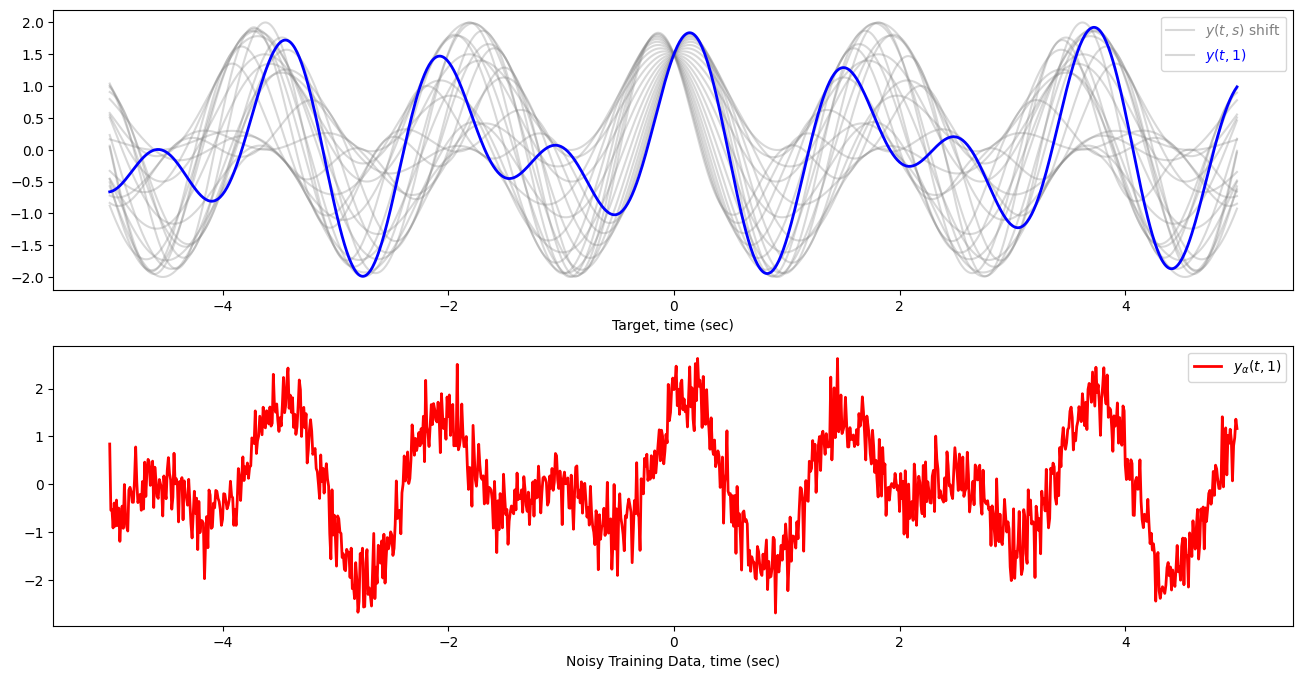

In [5]:
## SOLUTION REQUIRED IN THIS BLOCK ##

## Plotting simulated functional data

t_line = np.arange(-5., 5., 1/100.) # line space
alpha = 0.4
## Creating a function to produce cyclical y data.
def y_func(s):
    return np.sin(np.sin(s) * 2 * np.pi * t_line + np.pi / 6) + np.cos(2 * (np.sqrt(3)) * t_line)
 ## SOLUTION REQURIED HERE ##
y = y_func(1)
## Adding noise
y_noisy = y + np.random.normal(0, 1, len(t_line)) * alpha ## SOLUTION REQURIED HERE ##


## Plotting
fig, ax = plt.subplots(2,1, figsize=(16,8))
fval = np.arange(-1,1,0.1)

for i in fval:
    ax[0].plot(t_line, y_func(i), color='gray', alpha=.3,label="$sin(f)$ shift")

ax[0].plot(t_line, y, lw = 2,label = "fixed $f$",color="b")
ax[0].set_xlabel('Target, time (sec)')
ax[1].plot(t_line, y_noisy, lw = 2,c="r")
ax[1].set_xlabel('Noisy Training Data, time (sec)')
ax[0].legend(["$y(t,s)$ shift","$y(t,1)$"],labelcolor=["gray","b"])
ax[1].legend(["$y_{\\alpha}(t,1)$"])


In the figure above we can see the true output of the generating function, given a specific value of $s$ (blue), and various drifts according to different values of $s$ (gray).  In the bottom plot you can see the noisy data (training),  matching the blue graph in the top plot.

### Creating PyTorch RNN model

Here we create a basic PyTorch RNN class (inherits from `nn.Module`).  

* *input_size* – The number of expected features (dimensions) in the input t

* *hidden_size* – The number of features in the hidden state h

* *num_layers* – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.    

* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states.




For more information, please check the
[PyTorch nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) documentation.


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        # Adding a fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)

        # get final output
        output = self.fc(r_out)

        return output, hidden


In [7]:

# RNN Hyperparameters
input_size=1 # our data is 1-dim
output_size=1
hidden_dim=16
n_layers=2

# instantiate an RNN model
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


### RNN Training

Now we need to define a training function that takes the following hyper-parameters:  

* rnn : the RNN model object
* n_steps = on how many steps ($t$) to train the model (equivalent to "epochs").
* lag = the steps/datapoints lag between the training and target data.
* alpha = how much noise to add to the training data
* seq_length = how many datapoints  (time-series steps) to consider in each "epoch": $(t-k:t)$
* stride = the window size of the function (of which the seq_length will be divided).
* print_every = how often (in steps) to print a plot of the prediction against the target.

At each step, we have a lagged value of x, noisy lagged value of x (training), and a value of y (target not lagged).

P3Q2:  (5pts)

Fill out the missing code according to the function definition above

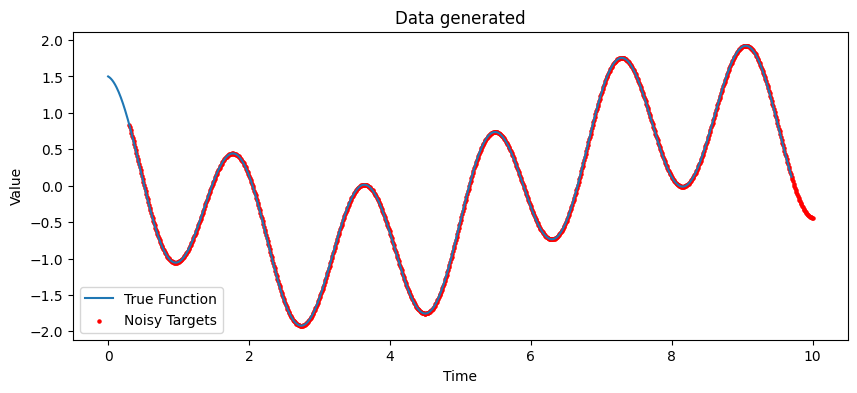

In [13]:
## SOLUTION REQUIRED IN THIS BLOCK##

# As above, creating a simulated data generator from our function (not noisy)
# this time, the function should depend on "step" as well (x_line is ever changing).

# y_func = ## SOLUTION NEEDED

# Function to simulate data
def y_func(s, t):
    return np.sin(np.sin(s) * 2 * np.pi * t + np.pi / 6) + np.cos(2 * np.sqrt(3) * t)

# Simulated Data Generator
def generate_data(n_steps, lag, alpha, seq_length, stride):
    """
    Generate training data based on y_func
    n_steps : Total number of time steps to generate
    lag : Lag between input data and targets
    alpha : Level of added noise
    seq_length : Length of training sequences
    stride : Steps between consecutive sequences
    """
    t = np.linspace(0, n_steps / 100, n_steps)
    s = np.random.uniform(0, 2 * np.pi)

    y = y_func(s, t)
    y_noisy = y + alpha * np.random.randn(len(y))

    x_train = []
    y_train = []
    for i in range(0, len(y_noisy) - seq_length - lag, stride):
        x_train.append(y_noisy[i:i + seq_length])
        y_train.append(y[i + seq_length + lag])
    return np.array(x_train), np.array(y_train),t,y

n_steps = 1000
lag = 10
alpha = 0.1
seq_length = 20
stride = 1

x_train, y_train, t, y = generate_data(n_steps, lag, alpha, seq_length, stride)

# Visualization of generated data
plt.figure(figsize=(10, 4))
plt.plot(t[:-lag - seq_length], y[:-lag - seq_length], label="True Function")
plt.scatter(t[seq_length + lag:], y_train, color="red", label="Noisy Targets", s=5)
plt.title("Data generated")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [14]:
# train the RNN
def train(rnn,y_func, n_steps, print_every,stride,seq_length,
          alpha,lag):
    # initialize the RNN hidden state
    hidden = None
    s = 1 # initialize f
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data

        # t_line = np.linspace(y_func(s,step),y_func(s,step)+stride,seq_length+stride)
        t_line =  np.linspace(step,step+stride, seq_length)
        data = y_func(s,t_line)
        noisy_data =  data + np.random.randn(len(t_line))*alpha
        # update f
        s += 0.05

        # prepare data for training
        data.resize((seq_length , 1)) # input_size=1
        noisy_data.resize((seq_length , 1)) # input_size=1
        # creating a lag in the noisy data aginst y
        x = noisy_data[:-lag]
        y = data[lag:]

        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero out gradients
        optimizer.zero_grad()
        # calculate backprop and update weights
        loss.backward()
        optimizer.step()

        # plot loss and predictions
        if batch_i%print_every == 0:
            plt.plot(t_line[lag:], x, 'r.',label = "training")
            plt.plot(t_line[lag:], y, 'b.',label = "actual")
            plt.plot(t_line[lag:], prediction.data.numpy().flatten(), 'y.',label= "prediction") #
            plt.title("Loss: {:,}".format(loss.item()))
            plt.legend(loc="upper left")
            plt.show()

    return rnn

# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

    
Train the RNN model on various hyper-parameters (defined below) and review the results.   


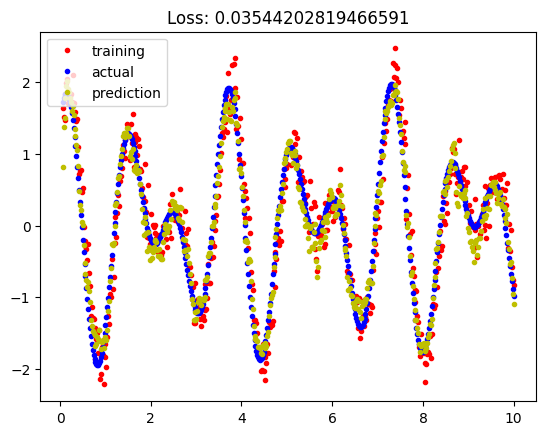

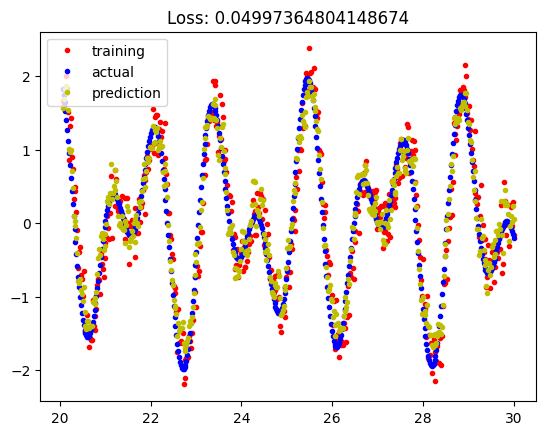

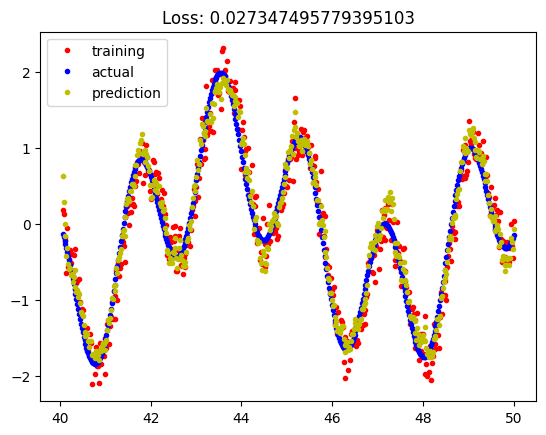

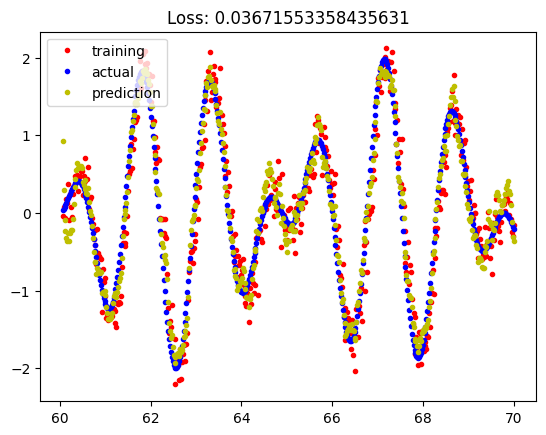

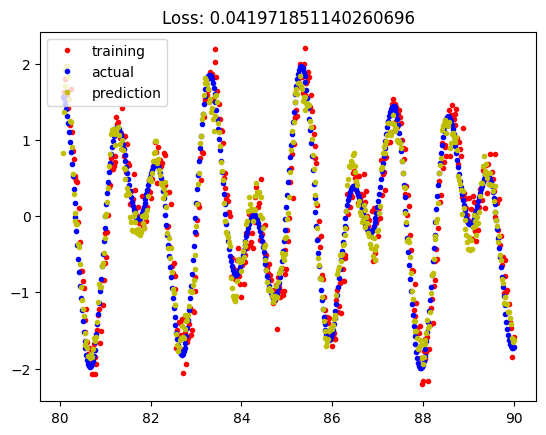

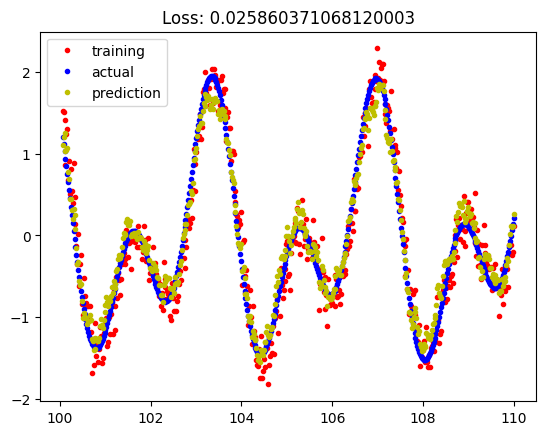

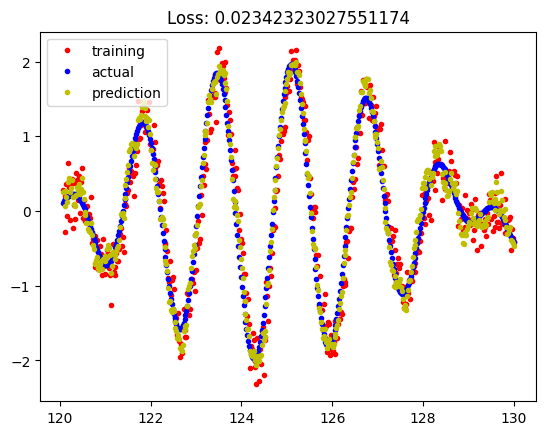

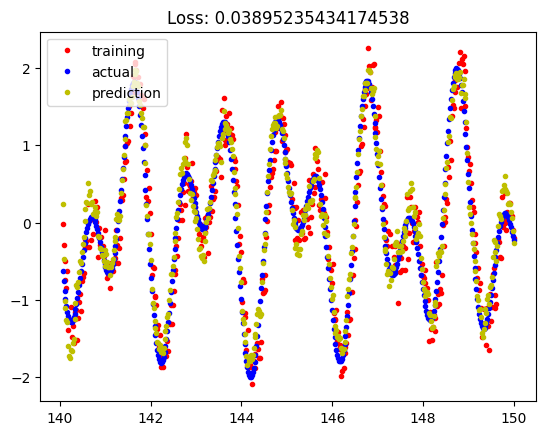

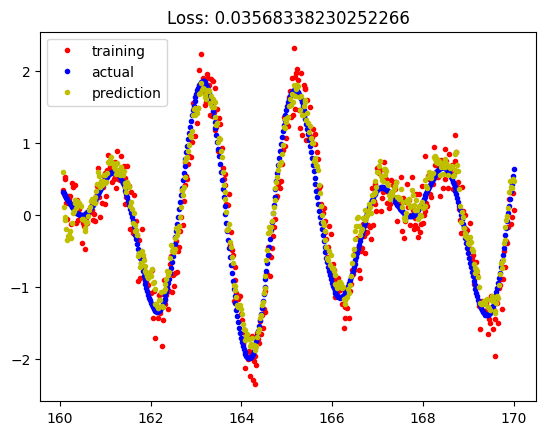

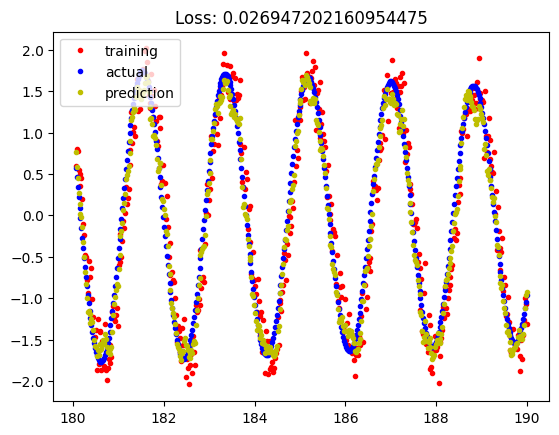

In [15]:

# train the rnn and monitor results

n_steps = 200
stride = 10
lag = 3
alpha = 0.2
seq_length = 500
print_every = 20

trained_rnn = train(rnn, y_func,  n_steps, print_every,
                    stride,seq_length,alpha,lag)

P3Q3: (10pts)

(a) Do you think our model performs well?     
(b) Write about the relationships and interplay between the different hyper-parameters, and explain how they effect the RNN model. Please relate also to the RNN architecture in our solution.

(c) Can you give a real world example where this type of model can be applied?   
(d) What would you change to improve it?

Write your solution here!

a) Yes, the model performs well overall. Its predictions closely match the actual values, especially for smooth and repetitive patterns. The low loss value (0.025) indicates that the model effectively minimizes the error between predictions and targets. However, there are some minor mismatches, particularly at sharp peaks or valleys, where the model either overshoots or lags slightly. Additionally, the noise in the training data impacts the predictions to some extent.

b) Sequence Length (seq_length):
Longer sequences allow the model to learn temporal patterns more effectively. However, sequences that are too long can increase computational cost and may lead to instability during training due to vanishing gradients.
Lag (lag):
A small lag makes the task easier since the predictions are closer to the input data. A large lag, however, increases the difficulty as the model needs to forecast further into the future.
Noise (alpha):
Higher noise levels (alpha) make the learning process harder as the model must filter out random variations. Reducing noise can help, but too little noise might result in overfitting to the exact data without capturing the general trend.
Stride (stride):
A smaller stride increases overlap between sequences, which can improve learning but adds redundancy. Larger strides speed up training but might miss important patterns.
RNN Architecture:
The current model uses a simple RNN, which works well for short-term dependencies. However, for more complex patterns, LSTMs or GRUs are better as they can capture long-term dependencies more effectively.

c) This model can be applied to forecasting tasks, such as:

Energy Demand Prediction: Estimating future electricity usage based on past consumption patterns.
Weather Forecasting: Predicting temperature, rainfall, or wind speeds using historical data.
Financial Markets: Forecasting stock prices or currency trends.
Healthcare: Monitoring patient health data, like heart rates or blood sugar levels, to predict future trends.

d) Reduce Noise:
Preprocess the data to reduce noise (alpha) or apply denoising techniques to improve predictions.
Increase Training Steps:
Train the model for more steps (n_steps) while monitoring performance to ensure convergence.


THE END!